In [1]:
#########################################################################################################################
################################################### LOADING AND LABEL ###################################################
#########################################################################################################################

In [5]:
!pip install -q keras==2.10.0

In [1]:
!pip show keras

Name: keras
Version: 2.10.0
Summary: Deep learning for humans.
Home-page: https://keras.io/
Author: Keras team
Author-email: keras-users@googlegroups.com
License: Apache 2.0
Location: /home/jrneto/.local/lib/python3.7/site-packages
Requires: 
Required-by: tensorflow


In [1]:
!python --version
!conda --version

import os
#os.environ["SM_FRAMEWORK"] = "tf.keras"

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
#!pip install 'h5py==2.10.0' --force-reinstall

import sys
#!{sys.executable} -m pip install -U segmentation-models
import segmentation_models as sm 
#!{sys.executable} -m pip install -U albumentations>=0.3.0

#!{sys.executable} -m pip install -U albumentations[imgaug]
#!{sys.executable} -m pip install glob2

#from skimage.io import imread, imshow
#from skimage.transform import resize

Python 3.7.13
conda 23.7.4


2024-06-19 10:57:29.761241: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 10:57:29.884615: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-19 10:57:30.438631: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-19 10:57:30.438700: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

Segmentation Models: using `keras` framework.


In [2]:
%load_ext autoreload
%autoreload 2

# Old Code

In [ ]:
DATA_DIR = 'segmentation_224_withoutFullPositive'

x_train_dir = os.path.join(DATA_DIR, 'train/image/img')
y_train_dir = os.path.join(DATA_DIR, 'train/mask/img')

x_valid_dir = os.path.join(DATA_DIR, 'val/image/img')
y_valid_dir = os.path.join(DATA_DIR, 'val/mask/img')

x_test_dir = os.path.join(DATA_DIR, 'test/image/img')
y_test_dir = os.path.join(DATA_DIR, 'test/mask/img')

In [ ]:
# rm -rf `find -type d -name .ipynb_checkpoints`

In [ ]:
import os.path

path = x_test_dir

num_files = len([f for f in os.listdir(path)if os.path.isfile(os.path.join(path, f))])
print(path)
print(num_files)

In [ ]:
import os
import tensorflow as tf

from glob2 import glob

def process_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, size=(28, 28))
    return img

x_train_files = glob(x_train_dir + '/*.jpg')
y_train_files = glob(y_train_dir + '/*.jpg')

train_files_ds = tf.data.Dataset.from_tensor_slices((x_train_files, y_train_files))

train_files_ds = train_files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(1)

x_train, y_train = next(iter(train_files_ds))

#print(y_train)

In [ ]:
x_val_files = glob(x_valid_dir + '/*.jpg')
y_val_files = glob(y_valid_dir + '/*.jpg')

val_files_ds = tf.data.Dataset.from_tensor_slices((x_val_files, y_val_files))
val_files_ds = val_files_ds.map(lambda n, h: (process_img(n), process_img(h))).batch(1)
x_val, y_val = next(iter(val_files_ds))

x_test_files = glob(x_test_dir + '/*.jpg')
y_test_files = glob(y_test_dir + '/*.jpg')

test_files_ds = tf.data.Dataset.from_tensor_slices((x_test_files, y_test_files))
test_files_ds = test_files_ds.map(lambda x, y: (process_img(x), process_img(y))).batch(1)
x_test, y_test = next(iter(test_files_ds))

#print(x_val)
#print(y_val)
#print(len(x_val))

# Datasets

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:    
    CLASSES = ['metastasis']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            these_ids=None,
            start_index=None,
            end_index=None,
    ):
        if these_ids is None:
            self.ids = sorted(os.listdir(images_dir))
            if start_index is not None:
                self.ids = self.ids[start_index:end_index]
        else:
            self.ids = these_ids
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        self.see = False
    
    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        #try:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #except:
        #    print('-----------------------')
        #    print(i)
        #    print(self.images_fps[i])
        #    print('-----------------------')
        #    raise self.images_fps[i]
        mask = cv2.imread(self.masks_fps[i], 0)
        #mask = cv2.imread(self.masks_fps[0], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        mask = (~mask.astype(bool)).astype(float)
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        #return image/255, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        
        #data = []
        image = []
        mask  = []
        
        for j in range(start, stop):
            #data.append(self.dataset[j])
            img, msk = self.dataset[j]
            image.append(img)
            mask.append(msk)
            
        image = np.array(image)
        mask  = np.array(mask)
        return image, mask
        
        # transpose list of lists
        #batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        #return batch
        #return batch[0], batch[1]
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)   

In [4]:
import albumentations as A
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.Transpose(p=0.3),
        A.RandomRotate90(p=0.3),

        #A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        #A.PadIfNeeded(min_height=224, min_width=224, always_apply=True, border_mode=0),
        #A.RandomCrop(height=224, width=224, always_apply=True),

        A.transforms.GaussNoise (p=0.2),
        #A.geometric.transforms.Perspective (p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightnessContrast(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.transforms.Sharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomBrightnessContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        )#,
        #A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        A.PadIfNeeded(224, 224)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

In [5]:
BACKBONE = 'resnet50' #'resnet50'
# resnet50_imagenet_1000_no_top.h5
BATCH_SIZE = 32
CLASSES = ['metastasis']
LR = 0.001
#LR = 0.0001
#LR = 0.00001
EPOCHS = 50

preprocess_input = sm.get_preprocessing(BACKBONE)

To restart the model, run from here

In [6]:
# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_freeze=True)#, input_shape=(256, 256, 3))

2024-06-19 10:57:39.799464: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 10:57:40.438035: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13600 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:41:00.0, compute capability: 7.5


In [ ]:
model.summary()

Unfrozen last layers

In [8]:
for i in range(len(model.layers)):
    #if 'stage4_unit3_' in model.layers[i].name:
    if i >= 0 and i <= 189:
    #if 'center_' in model.layers[i].name:
        print(model.layers[i].name, i)
        model.layers[i].trainable = True

data 0
bn_data 1
zero_padding2d 2
conv0 3
bn0 4
relu0 5
zero_padding2d_1 6
pooling0 7
stage1_unit1_bn1 8
stage1_unit1_relu1 9
stage1_unit1_conv1 10
stage1_unit1_bn2 11
stage1_unit1_relu2 12
zero_padding2d_2 13
stage1_unit1_conv2 14
stage1_unit1_bn3 15
stage1_unit1_relu3 16
stage1_unit1_conv3 17
stage1_unit1_sc 18
add 19
stage1_unit2_bn1 20
stage1_unit2_relu1 21
stage1_unit2_conv1 22
stage1_unit2_bn2 23
stage1_unit2_relu2 24
zero_padding2d_3 25
stage1_unit2_conv2 26
stage1_unit2_bn3 27
stage1_unit2_relu3 28
stage1_unit2_conv3 29
add_1 30
stage1_unit3_bn1 31
stage1_unit3_relu1 32
stage1_unit3_conv1 33
stage1_unit3_bn2 34
stage1_unit3_relu2 35
zero_padding2d_4 36
stage1_unit3_conv2 37
stage1_unit3_bn3 38
stage1_unit3_relu3 39
stage1_unit3_conv3 40
add_2 41
stage2_unit1_bn1 42
stage2_unit1_relu1 43
stage2_unit1_conv1 44
stage2_unit1_bn2 45
stage2_unit1_relu2 46
zero_padding2d_5 47
stage2_unit1_conv2 48
stage2_unit1_bn3 49
stage2_unit1_relu3 50
stage2_unit1_conv3 51
stage2_unit1_sc 52
add_3

In [9]:
import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, ReduceLROnPlateau

In [10]:
# define optomizer
optim = keras.optimizers.Adam(LR)
#optim = tf.keras.optimizers.RMSprop(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + focal_loss
#total_loss = keras.losses.BinaryCrossentropy(from_logits=True)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

#metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(), sm.metrics.Recall(), tf.keras.metrics.AUC()]
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(), sm.metrics.Recall(), tf.keras.metrics.AUC()]

# compile keras model with defined optimozer, loss and metrics
model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
#model.compile(optimizer=optim, loss=[dice_loss,focal_loss], metrics=metrics)

In [11]:
#x_train_dir_t = 'segmentation_224_withoutFullPositive/train/image/img'
#y_train_dir_t = 'segmentation_224_withoutFullPositive/train/mask/img'
#x_valid_dir_t = 'segmentation_224_withoutFullPositive/val/image/img'
#y_valid_dir_t = 'segmentation_224_withoutFullPositive/val/mask/img'

Fixed dataset to avoid bad sampling or bad splitting

No data-leakage between patients, since no patches of the same patient were split into train/val

In [11]:
x_train_dir_t = 'segmentation_without_full_positive_center112_level3/image/img'
y_train_dir_t = 'segmentation_without_full_positive_center112_level3/mask/img'
x_valid_dir_t = 'segmentation_without_full_positive_center112_level3/image/img'
y_valid_dir_t = 'segmentation_without_full_positive_center112_level3/mask/img'
train_start_index=0
train_end_index=3494
val_start_index=3494
val_end_index=None

In [12]:
# Dataset for train images
train_dataset = Dataset(
    x_train_dir_t, 
    y_train_dir_t, 
    classes=CLASSES, 
    start_index=train_start_index,end_index=train_end_index,
    augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

#train_dataset.masks_fps = ['segmentation_224px/train/mask/img/001_70560_124768.jpg']

# Dataset for validation images
valid_dataset = Dataset(
    x_valid_dir_t, 
    y_valid_dir_t, 
    classes=CLASSES, 
    start_index=val_start_index,end_index=val_end_index,
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 224, 224, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 224, 224, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving


In [13]:
model.evaluate(valid_dataloader)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set

2024-04-01 11:28:44.393919: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


32/32 [==============================] - 10s 142ms/step - loss: 0.7772 - iou_score: 4.5926e-06 - f1-score: 9.1852e-06 - precision: 0.5283 - recall: 0.2537 - auc: 0.4653


[0.7772426009178162,
 4.592634468281176e-06,
 9.18519617698621e-06,
 0.5282970070838928,
 0.25369516015052795,
 0.46533674001693726]

# Dataset Augmentation

In [ ]:
## Careful
raise 'Careful'
augmentation_nf = get_training_augmentation()
aug_x_train_dir = 'segaug5/train/image/img'
aug_y_train_dir = 'segaug5/train/mask/img'
aug = 0
max_aug = 5

for i in range(len(train_dataset)):
    filename = train_dataset.images_fps[i].split('/')[-1][0:-4]
    image, mask = train_dataset[i]
    #visualize(img=image, msk=mask)

    for j in range(aug, max_aug):
        sample = augmentation_nf(image=image, mask=mask)
        aug_image, aug_mask = sample['image'], sample['mask']
        
        #visualize(img=aug_image, msk=aug_mask)
        #print(aug_x_train_dir+'/'+filename+'_'+str(j)+'.jpg')
        #print(aug_y_train_dir+'/'+filename+'_'+str(j)+'.jpg')

        cv2.imwrite(aug_x_train_dir+'/'+filename+'_'+str(j)+'.jpg', cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
        cv2.imwrite(aug_y_train_dir+'/'+filename+'_'+str(j)+'.jpg', (~aug_mask.astype(bool)).astype(float))
    #raise 'ee'

# Dataset Vizualization

In [23]:
def maskImg(img, threshold):
    mask = img.copy()
    mask[mask <= threshold] = np.nan
    return mask
def vizMsk(img, msk):
    fig, axarr = plt.subplots(1,1, figsize=(16, 5))
    axarr.imshow(img, interpolation='None')
    axarr.imshow(maskImg(msk, 0), alpha=0.8, cmap='bone', interpolation='None')
    plt.show()

In [ ]:
img_original = train_dataloader[0][0][i]
msk_original = train_dataloader[0][1][i]

In [ ]:
for jj in range(10):
    vizMsk(train_dataloader[0][0][jj], train_dataloader[0][1][jj])

In [ ]:
i = 1

bat = train_dataloader[0]
img = bat[0][i]
msk = bat[1][i]

print(img.shape)
print(msk[0][0])

#visualize(img=img, msk=msk)
vizMsk(img, msk)
plt.imshow(msk)
plt.show()
#vizMsk(img_original, msk_original)
return

fnaug = get_training_augmentation()
augmentedimg = fnaug(image=img, mask=msk)
#augmentedimg['mask'] = (~augmentedimg['mask'].astype(bool)).astype(float)
#visualize(img=augmentedimg['image'], msk=augmentedimg['mask'])
print(augmentedimg['mask'][0][0])
vizMsk(augmentedimg['image'], augmentedimg['mask'])
plt.imshow(augmentedimg['mask'])
plt.show()

cv2.imwrite('./teste_img.jpg', cv2.cvtColor(augmentedimg['image'], cv2.COLOR_RGB2BGR))
msk2 = (~augmentedimg['mask'].astype(bool)).astype(float)
plt.imshow(msk2)
plt.show()
cv2.imwrite('./teste_msk.jpg', msk2)

image = cv2.imread('./teste_img.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
mask = cv2.imread('./teste_msk.jpg', 0)
masks = [(mask == v) for v in train_dataloader.dataset.class_values]
mask = np.stack(masks, axis=-1).astype('float')

# add background if mask is not binary
#if mask.shape[-1] != 1:
#    background = 1 - mask.sum(axis=-1, keepdims=True)
#    mask = np.concatenate((mask, background), axis=-1)
    
print(mask[0][0])
vizMsk(image, mask)
plt.imshow(mask)
plt.show()

# Training Callbacks

In [13]:
BEST_MODEL_FILEPATH = './models/new_model_segmentation.h5'

learn_control = ReduceLROnPlateau(monitor='val_loss',
                                  mode='min',
                                                      patience=3,
                                                      #verbose=1,
                                                      factor=0.2,
                                                      min_lr=1e-8)

# ModelCheckpoint: When training requires a lot of time to achieve a good result, 
# often many iterations are required. In this case, it is better to save a copy 
# of the best performing model only when an epoch that improves the metrics ends.

checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, 
                                                 monitor='iou_score', 
                                                 #verbose=1, 
                                                 save_best_only=True, 
                                                 mode='max'
                                                 )
callbacks = [learn_control]#,checkpoint]

In [14]:
print(len(train_dataloader))
print(len(valid_dataloader))

109
32


In [32]:
# load best weights
#model.load_weights(BEST_MODEL_FILEPATH)

# Training with K-fold

In [ ]:
from sklearn.model_selection import KFold
from sklearn.utils import check_random_state

In [ ]:
def build_new_model():
    model = sm.Unet(BACKBONE, classes=n_classes, activation=activation, encoder_freeze=True)

    for i in range(len(model.layers)):
        if i >= 177 and i <= 189:
            #print(model.layers[i].name, i)
            model.layers[i].trainable = True
    
    optim = keras.optimizers.Adam(LR)
    
    dice_loss = sm.losses.DiceLoss()
    focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + focal_loss
    
    metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), sm.metrics.Precision(), sm.metrics.Recall(), tf.keras.metrics.AUC()]

    model.compile(optimizer=optim, loss=total_loss, metrics=metrics)
    
    return model

In [ ]:
k_fold_img = 'segmentation_without_full_positive_center112_level3/image/img'
k_fold_msk = 'segmentation_without_full_positive_center112_level3/mask/img'

train_dataset_uni = Dataset(
    k_fold_img, 
    k_fold_msk, 
    classes=CLASSES
)

train_dataloader_uni = Dataloder(train_dataset_uni, batch_size=BATCH_SIZE, shuffle=True)

# check shapes for errors
assert train_dataloader_uni[0][0].shape == (BATCH_SIZE, 224, 224, 3)
assert train_dataloader_uni[0][1].shape == (BATCH_SIZE, 224, 224, n_classes)

In [ ]:
#np.random.set_state(('MT19937', [4173618434,  294282122,  956382637, 3163337050,  294449887, 1199125307, 4286073898,  995602879, 3220210366, 1325958976, 2446304778, 4267875027, 1102127746, 3609408819, 2817490656, 1075410283, 3433639235,  111520407, 3218255182,  952782572, 1333933580, 1558056681, 2332710618, 2993699469, 1230619815, 607695969, 3908550652, 2685196097, 2688571240, 2371220525, 1985422136, 2114744213,   74813167, 2339706777, 1914105034, 2600127232, 1186245284, 1411859895, 3534107399, 2575205096, 1527050972, 1111526793, 1682042204, 1180441104, 3862226910, 3673600557, 2235089421,  598493335, 1196268390, 1569836427, 1007342192, 3139084222, 2578778357, 4214227377, 2572800021, 587137969, 1434038621, 1894104342, 2643672296, 3023647775, 1013222042,  389873378, 4004671183, 2553912848, 3231252612, 3087232054, 1305816576, 4164807077,  124072075, 2382230311, 727897747,   21514348,  524148613, 1573676195, 3545193727, 1229048278,  306040681, 3087088074, 3523399703, 1957539295, 1296429542, 1636849761, 3303849062, 1714964728, 4124694656, 2838766029, 4122824880, 2669672581, 4144085913, 3883735418, 2053599852, 1061009824, 2833996605, 1943673076, 1570001144, 459111234, 2173188191, 1925251112, 1803377133, 2560008415, 1014353336, 3831121828,  887741655, 1701810727, 1223062316, 67852553,  922013181, 1483577713, 3738884334, 1918802015, 2185703805, 1907208354, 1289078923, 3344303193, 1193077194, 3203791969, 1267177826, 3299260325,  261879332, 1240653226, 3036118151, 2831439603, 1107984342, 3634885812, 1266134542, 4174597083, 3081451552, 2107955383, 2427000553,  680893618, 3387791864, 3527198080, 2093379856,  652635534, 2720008102,2546027022, 2473953110,  780838794, 2782735128, 3982378080,4225638698, 4083025120, 2374421752,  925843708, 3242478517,2039388905,   53655480, 2000879674, 2039323938, 1788114726,2158757805, 1944927260, 4226439970,  432425885,  484178912,88549161, 1019785664, 2093557591, 2523104517, 2326249850,2216512935, 3620314961, 1809182595, 1780654121, 3928593360,4165703051, 1516152682, 2464962445, 1381641779,  670102407,3138679148, 1054764873, 1641328808,  555074874, 1683935052,367453084, 1904300314, 3069575858, 2100262440, 2059759374,4077254948,  234117250, 1642592100, 1649984382, 2321575533,213859131, 2774266638, 3815272330, 3063781075, 1264756515,4063857544, 4076552427, 2809723334, 3552757561, 4134586665,2835074725, 3084143793, 3375598474, 3012836787, 1620251454,2167337846, 3408155685, 3962335866, 3602239053, 1658061775,4257689447, 2534529655, 1386078584,  917529331, 4243760802,3549731788, 1006728290, 2176994318, 4046515690, 1694303008,1728598085,  843088375, 2759144075, 2139891451, 3800235450,501600339,  790652561, 4075505102, 2130344613,  304998828,3829330117, 1732943104,  744627693, 4050902983, 3374709209,1810096281, 3584393399, 2843349245, 2879402654, 2464922298,1242629769, 3308252043, 3396260687, 2400344020,  785772417,2474790319, 3989738040, 2564449147, 3109527852, 4095323468,445219141,  657236439, 1955157360, 1220266891,  478237123,3361783957, 2010568514, 1268002642,  870558300, 2756166878,229581501, 2745166329, 2237820177, 1432867530, 1782010675,1227643741, 2681352720, 1000784525, 1762182977, 2762154198,2318243478,  325609242, 2435332937, 1634616601, 2564173809,1361329180, 3776688858, 3412368780,  236191265, 2444866876, 3099267448, 2134680622, 4063054852, 2397948876,  960385402, 1858459376, 4227181221, 3151397838, 2931926124, 1767747616,104419681, 1653934528,  722831457, 1502907076, 4192292246,2503571991, 1479999352, 2745007034, 3296250229, 2366376184,394232100,  423244079, 2617281059,  652461560,  256797587,412099133, 1166926656, 2076415574,  542217469, 2101530212,2418938010, 2679433956,  107241386, 1261171721,  181582719,3300037978, 1198182834,  467478696, 2369056706, 3858520670,313143854, 4246685633, 1954682826, 3160699580, 4257883982,1877849614, 3155068931, 1295631499, 2635140330,  355110915,3162551571,   78863964, 3193698175, 3259114524, 2769898539,1546252416, 2979942041, 3282716645,  582471371, 3973912555,41190191, 4267104453, 2460322093,  813992721, 3744642268, 1619601881, 1311959912, 2247559583, 2406069410, 4233408276,1219010913, 3348372882,  317086573,  472770739,  845141043,525331428, 1000452129, 2752028783, 1874707964, 3975271761,3667737142,  204946285, 3192440958, 2241784388, 1236806614,996057527, 3146442038, 1807507121, 3527247674,  123889875,3379344206,  307109439, 2053118860, 1944338187, 1866496265,588331126,  640725850, 2086832216, 1857069130, 3729973992,3094022016, 1873632005, 2162224627, 2649079761, 4171517810,1069672923, 3896705751, 1885124090,  373345096, 2215363143,157011431, 2711661215, 1544090720,  324719781, 3579649012,2954685451,  629101097, 1994914806,  647178787,  862041049,1676427669, 1783906961, 2245699887,   67234561, 2397577656,2400522244, 3886364078,  277861181, 4012068866,  562887383,3108668722, 1443553928,  126705630, 3504274344, 3069744695,3000189071, 3157387326, 2087555010, 3039935395, 1995477815,3212835178, 2368427036, 2483343721, 1212828091, 3575475523,278687574,  492572994, 3991140911,  109400253, 3276780267,289983010, 3900623193, 4035451136, 3790635591, 1511386416, 2102842066, 2352053593,   79035358,  732759411, 3711979470,2886965502, 1006439434, 3476621662, 2394660727, 1329722982,2269250014, 3684618483, 2605286119,  458489773, 3902743979,2835730152, 2509033785, 1931995826, 1422867953, 2560240811,1472947704, 2807181809, 1966515485, 1124347954,  643261133,4268646907, 2103249031, 2686711633,  721685681,  957920839, 1950298462, 1473781162, 1880135288, 3508433639, 3449163898, 4033972935, 2689977857, 3262692506, 2640114678, 3669664881, 468577619,  915844537, 2549199076,  145939328, 2635714362, 1925820013, 3584932069, 2187040595, 1332366701, 4018001655, 1140816501, 4263851337,   18107266, 1608236054, 2299858868, 4082105993, 2149989433, 1081914425, 3403943340, 2197392007, 792896728, 2824117875,  686446209, 2458510431, 2254603468, 3044320836, 2663063191, 3902234600,  556473484, 1520304422, 1771928935,  982950686, 3316983831, 3468373598, 4259083991, 225302648, 1877994359, 2371839183,  745719674,  552466587, 1082395032, 2319740986, 3579290234, 2007199556, 2027769284, 4159028666, 3924344671,  757532912, 3014578921, 3265684970, 2809132721, 1942044621, 1166985428,  532789364, 2077912455, 1434697735, 3399095866, 3460164710, 3986351429, 4084188288, 1612696062,  878877438,  522773884, 1426483508, 2831305429, 1498309049,  761236456, 3983052461, 2395693530, 1462473436, 1260343287,  881603889,  456954336, 4215607736, 3586543134, 3554622573, 1533715163, 2476929797, 3445107652, 2667732802, 1872204775, 2205560908, 3551303652, 1393301998, 2386863225, 1484370776, 4158012462, 3363119594, 3367202280, 4144962993, 2807555136,  320844771, 3065596311, 3944996833, 3682832436, 3402410971, 2986994917, 3111870903, 1494974980, 2345014945, 3805299238, 1849553391, 3391370161,  687460739, 2957364935, 1677369785, 1786720072,  864331575, 3275976561,  871378326, 3777240726, 3578840254,  399554777,  513259293, 2710466589, 2814258428, 2389236368, 1257875258,  731772793, 4249156813, 1049516399, 3398769923, 3791283210, 1571831439, 4002894097, 328000621, 1815616166, 3183795569, 1190710185, 4125271718, 2354950051,  917433392, 1850731061, 3192117651, 3649181184, 1132308152, 3277027996, 3806011804, 3927666548,  830343378, 1702478451, 1219560025, 3698740240, 1153603782, 3782988289, 3269096684, 1787104109, 3846289551, 2058844083, 1050892617, 4034270035, 3809788787, 3178235870, 1446407184], 75, 0, 0.0))

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
kf.get_n_splits(train_dataset_uni.ids)

all_imgs = np.array(train_dataset_uni.ids)

i = 1
evals = []
for train_index, test_index in kf.split(all_imgs):
    print('------------------------------ FOLD '+str(i))
    #if i not in [3,4]:
    #    i = i + 1
    #    continue
    
    #print(train_index[:5], train_index[-5:])
    #print(test_index[:5], test_index[-5:])
    #print('---')
    #continue

    train_dt = Dataset(
        k_fold_img, 
        k_fold_msk, 
        classes=CLASSES, these_ids=all_imgs[train_index],
        preprocessing=get_preprocessing(preprocess_input)
    )
    test_dt = Dataset(
        k_fold_img, # ta unificado
        k_fold_msk, 
        classes=CLASSES, these_ids=all_imgs[test_index],
        preprocessing=get_preprocessing(preprocess_input)
    )

    train_dl = Dataloder(train_dt, batch_size=BATCH_SIZE, shuffle=True)
    test_dl = Dataloder(test_dt, batch_size=BATCH_SIZE, shuffle=True)
    
    kmodel = build_new_model()
    
    history = kmodel.fit(
        train_dl,
        #batch_size=BATCH_SIZE,
        steps_per_epoch=len(train_dl), 
        epochs=EPOCHS, 
        #callbacks=callbacks, 
        validation_data=test_dl, 
        validation_steps=len(test_dl),
    )
    
    evals.append(kmodel.evaluate(test_dl))
    
    i = i + 1

In [ ]:
#model.load_weights(BEST_MODEL_FILEPATH)
#model.load_weights('best_segmentation2.h5')

# Training

In [ ]:
%%time
# train model
history = model.fit(
    train_dataloader,
    #batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader),
)

Epoch 1/50
109/109 [==============================] - 66s 607ms/step - loss: 0.2499 - iou_score: 0.7794 - f1-score: 0.8727 - precision: 0.8392 - recall: 0.8133 - auc: 0.9425 - val_loss: 0.2962 - val_iou_score: 0.7275 - val_f1-score: 0.8288 - val_precision: 0.8076 - val_recall: 0.7950 - val_auc: 0.9245 - lr: 1.0000e-08
Epoch 2/50
109/109 [==============================] - 66s 603ms/step - loss: 0.2493 - iou_score: 0.7811 - f1-score: 0.8740 - precision: 0.8393 - recall: 0.8138 - auc: 0.9429 - val_loss: 0.2959 - val_iou_score: 0.7272 - val_f1-score: 0.8285 - val_precision: 0.8092 - val_recall: 0.7926 - val_auc: 0.9246 - lr: 1.0000e-08
Epoch 3/50
109/109 [==============================] - 65s 597ms/step - loss: 0.2495 - iou_score: 0.7793 - f1-score: 0.8730 - precision: 0.8395 - recall: 0.8136 - auc: 0.9428 - val_loss: 0.2966 - val_iou_score: 0.7251 - val_f1-score: 0.8265 - val_precision: 0.8120 - val_recall: 0.7863 - val_auc: 0.9243 - lr: 1.0000e-08
Epoch 4/50
109/109 [====================

In [17]:
model.save('new_best_segmentation.h5')

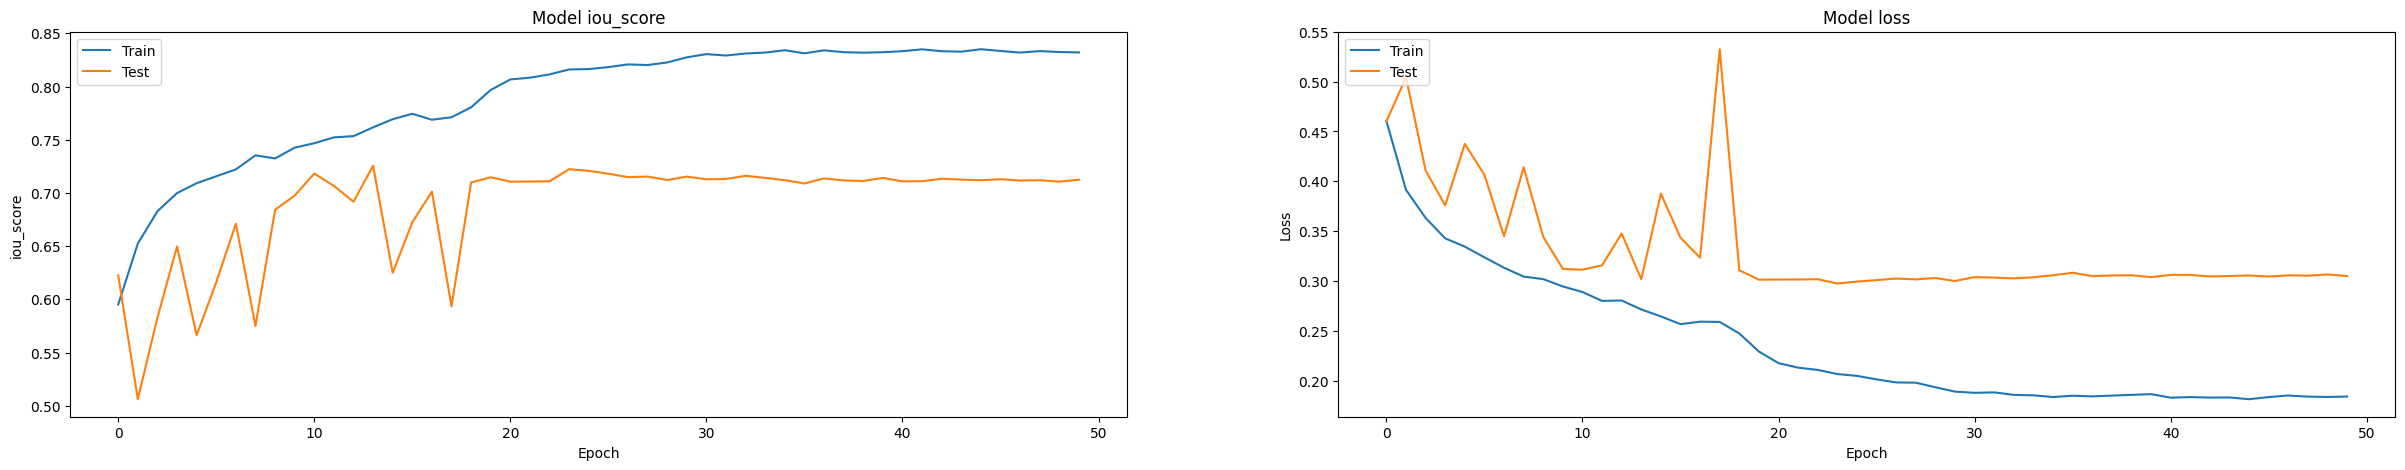

In [21]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

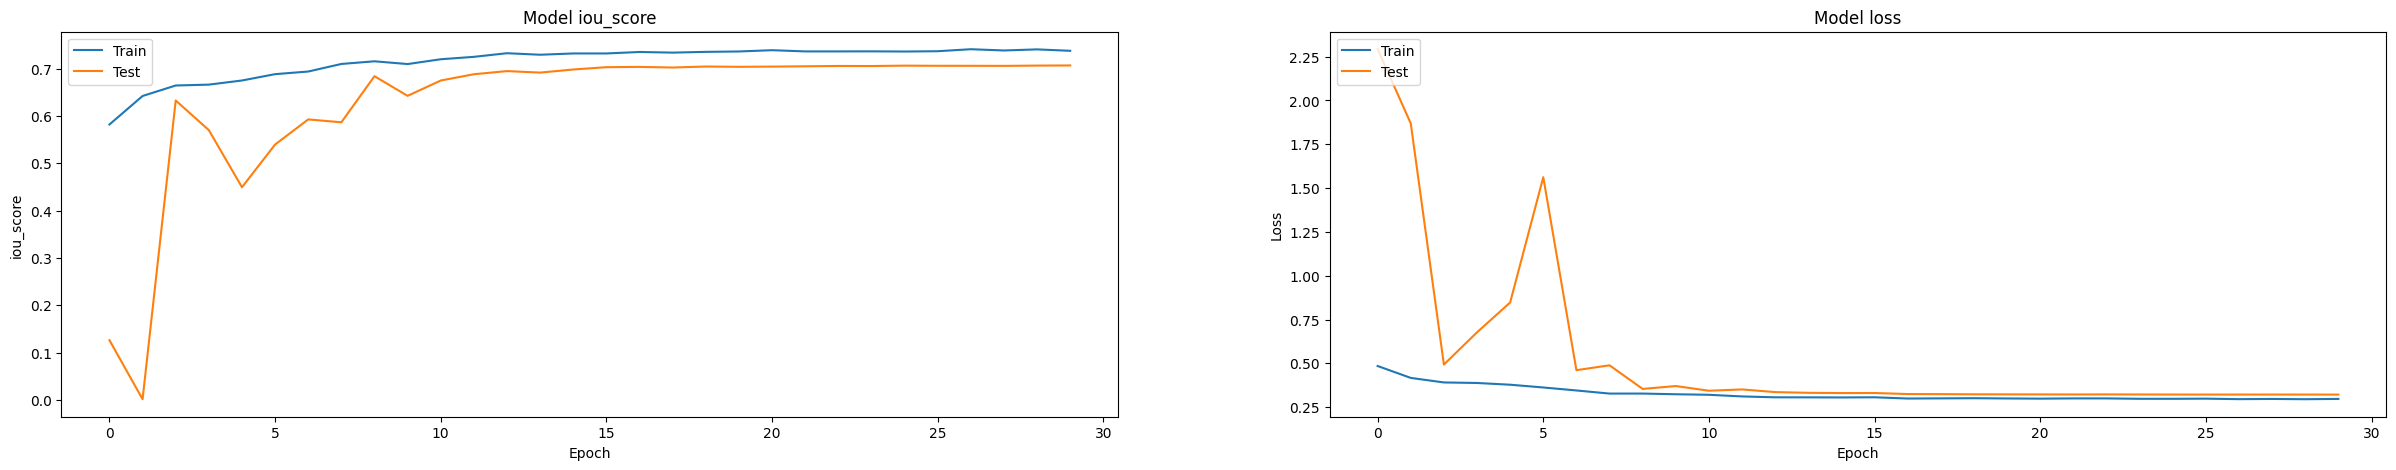

In [35]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

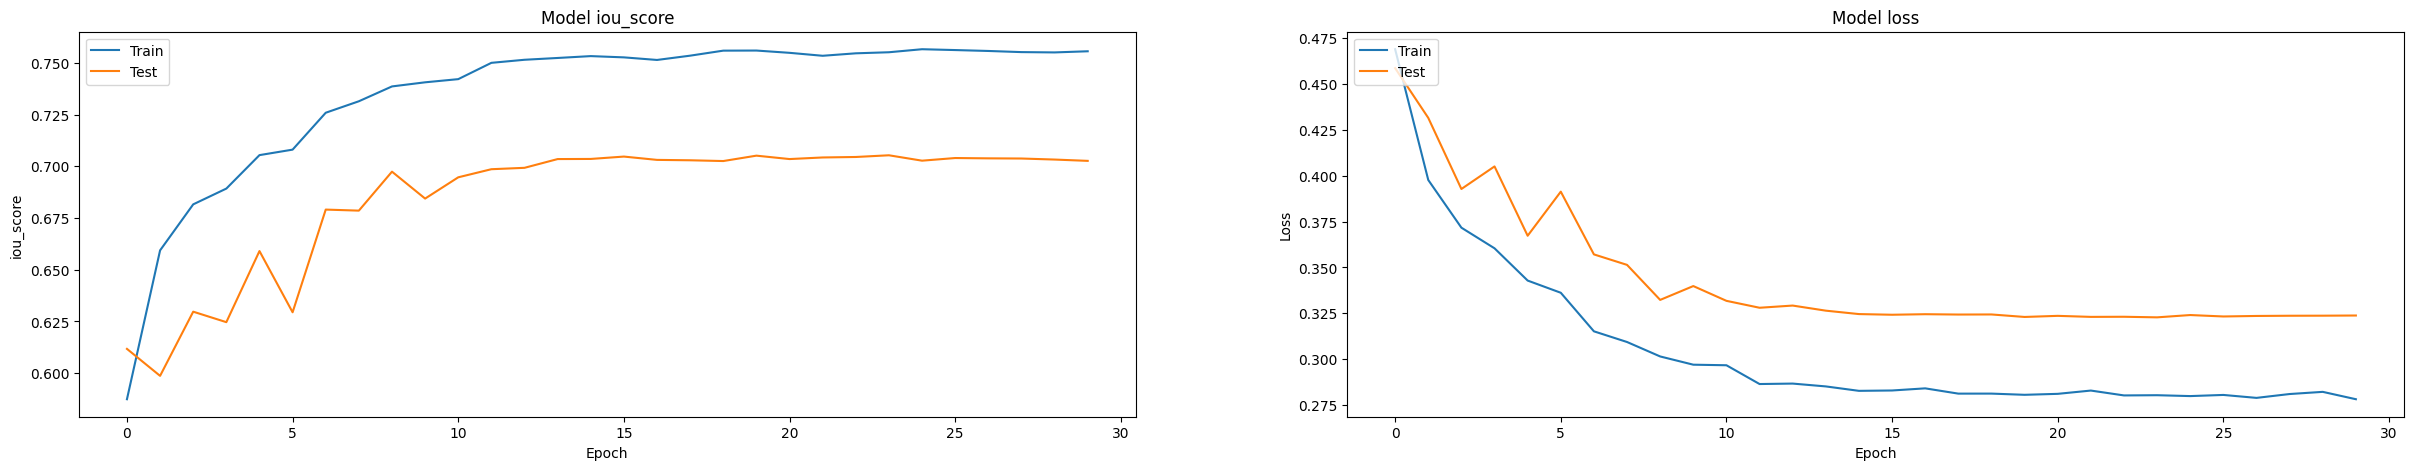

In [56]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

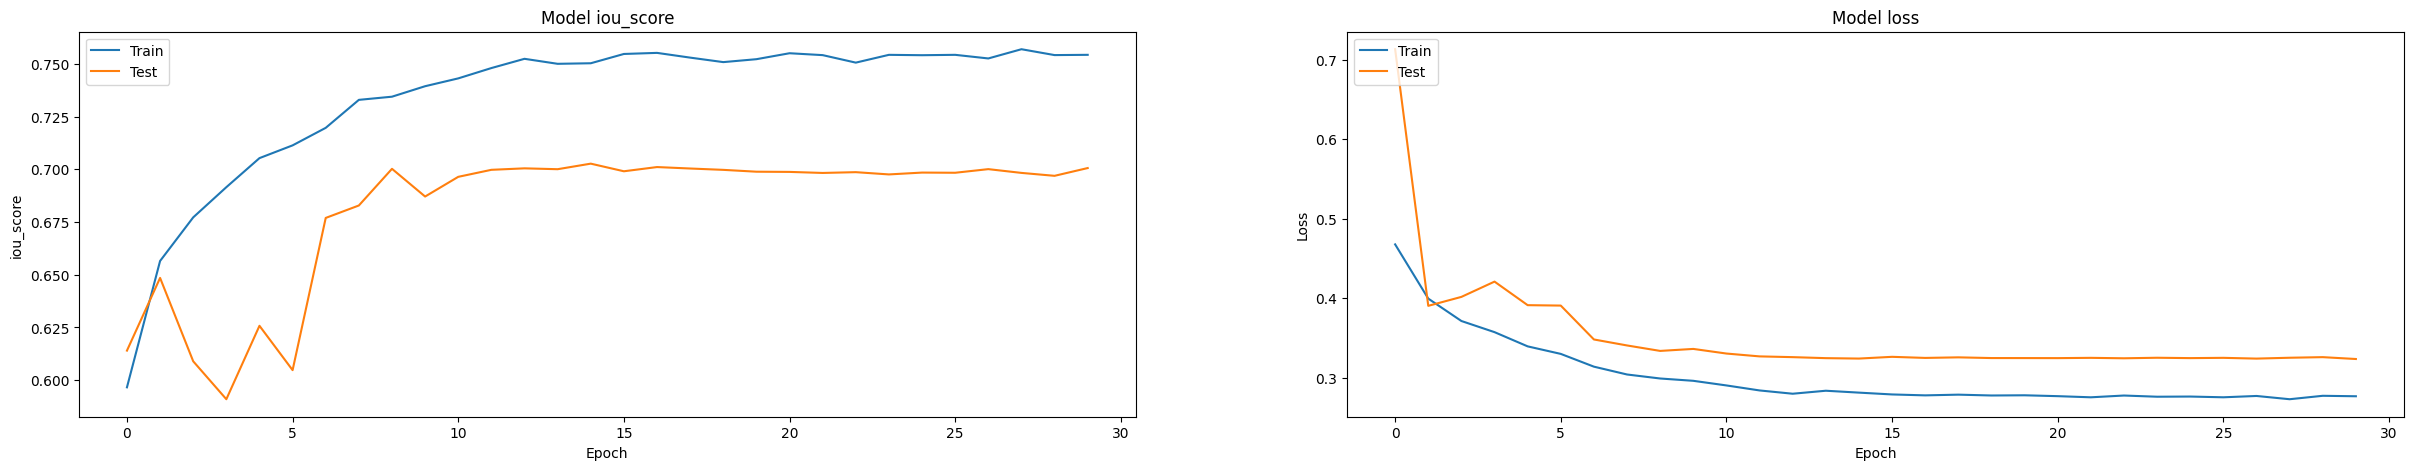

In [41]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

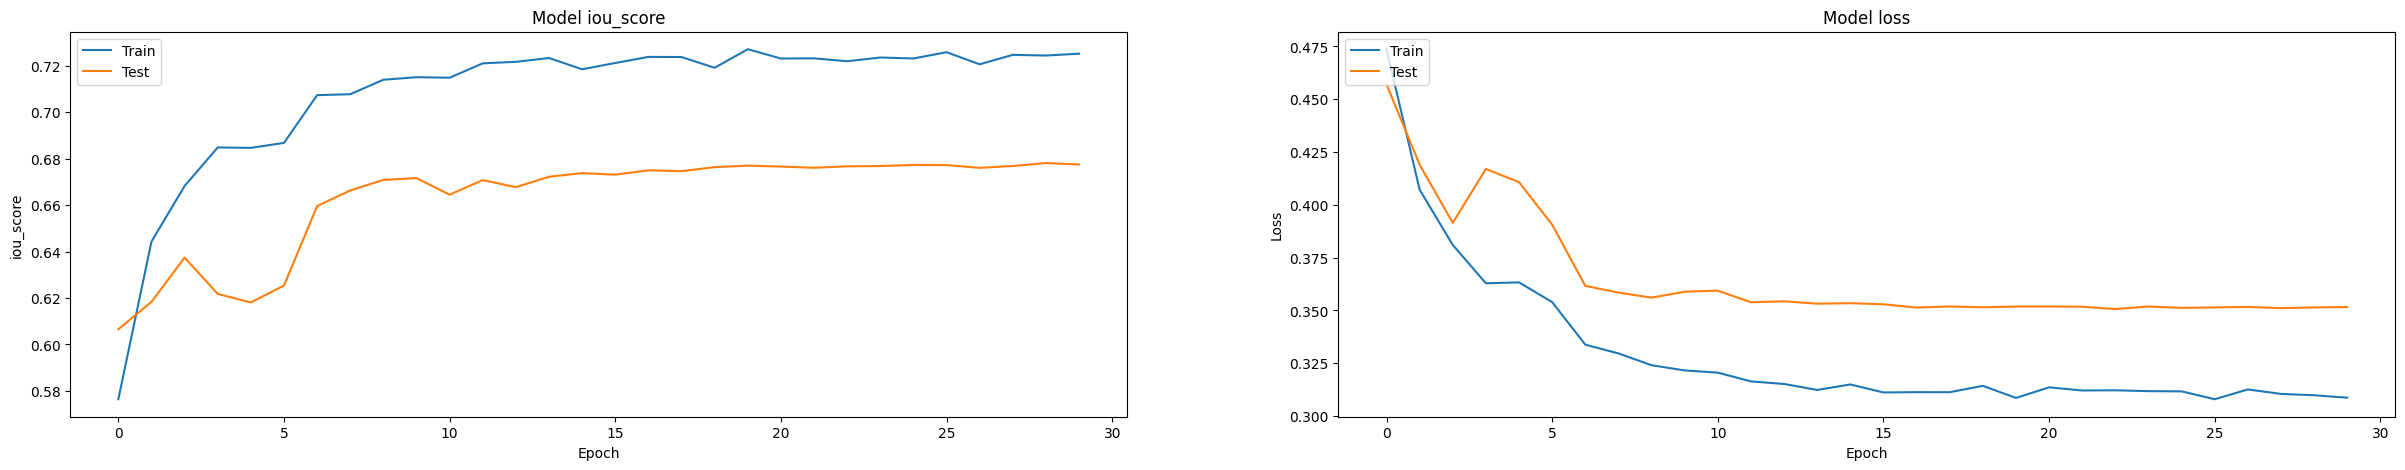

In [21]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Evaluating

In [15]:
model.load_weights('new_best_segmentation.h5')

In [17]:
model.evaluate(valid_dataloader)

32/32 [==============================] - 5s 141ms/step - loss: 0.3035 - iou_score: 0.7199 - f1-score: 0.8230 - precision: 0.8041 - recall: 0.7828 - auc: 0.9209


[0.3035312294960022,
 0.7199038863182068,
 0.8230052590370178,
 0.8041488528251648,
 0.7827920913696289,
 0.9209356307983398]

# Reconstruct - Patch predictions to images

In [17]:
test_dataset_final = Dataset(
    'segmentation_with_full_positive_center112_level3/image/img', 
    'segmentation_with_full_positive_center112_level3/mask/img', 
    #'segmentation_without_full_positive_center112_level3_test_slides/image/img', 
    #'segmentation_without_full_positive_center112_level3_test_slides/mask/img', 
    classes=CLASSES, 
    #start_index=val_start_index,end_index=val_end_index,
    #augmentation=get_training_augmentation(),
    #preprocessing=get_preprocessing(preprocess_input),
)
test_dataloader_final = Dataloder(test_dataset_final, batch_size=BATCH_SIZE, shuffle=False)

In [18]:
len(test_dataset_final)

396

In [19]:
model.evaluate(test_dataloader_final)

12/12 [==============================] - 2s 143ms/step - loss: 0.3077 - iou_score: 0.6822 - f1-score: 0.7920 - precision: 0.8077 - recall: 0.7144 - auc: 0.9406


[0.3076549172401428,
 0.6821592450141907,
 0.7920334339141846,
 0.8077439665794373,
 0.7143703103065491,
 0.9405555725097656]

In [20]:
#fig, axarr = plt.subplots(2,2, figsize=(12, 12))
for i in range(len(test_dataset_final)):
    #if i < 200:
    #    continue
    image_name = test_dataset_final.images_fps[i].split('/')[-1][:-4]
    #print(image_name)
    #if '109_19_51' not in image_name:
    #    continue
    image, mask = test_dataset_final[i]
    pred = model.predict(np.array([image])).round()
    #pred[0] = (~pred[0].astype(bool)).astype(int)
    
    #axarr[0,0].title.set_text('Tissue')
    #axarr[0,0].imshow(image)
    #axarr[0,1].title.set_text('Annotation')
    #axarr[0,1].imshow(image)
    #axarr[0,1].imshow(maskImg(mask, 0), alpha=0.5, cmap='Wistia', interpolation='None')
    #axarr[1,0].title.set_text('Prediction')
    #axarr[1,0].imshow(image)
    #axarr[1,0].imshow(maskImg(pred[0], 0), alpha=0.5, cmap='spring', interpolation='None')
    #axarr[1,1].title.set_text('Annotation VS Prediction')
    #axarr[1,1].imshow(mask, label='Annotation')
    #axarr[1,1].imshow(maskImg(pred[0], 0), alpha=0.5, cmap='spring', interpolation='None', label='Prediction')
    #axarr[1,1].set_xlabel('Annotation (Yellow)    Prediction (Pink)')
    #plt.show()
    #plt.imshow((pred[0].astype(bool)).astype(float))
    #break
    
    cv2.imwrite('Results4/'+image_name+'.jpg', (pred[0].astype(bool)).astype(float))
    #with open('Results3/'+image_name+'.npy', 'wb') as f:
    #    np.save(f, (pred[0][:,:,0].astype(bool)).astype(float))
    print('Results4/'+image_name+'.jpg')
    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 1s/step
Results4/002_100_21.jpg
1/1 [==============================] - 0s 20ms/step
Results4/002_101_22.jpg
1/1 [==============================] - 0s 19ms/step
Results4/002_101_23.jpg
1/1 [==============================] - 0s 19ms/step
Results4/002_102_22.jpg
1/1 [==============================] - 0s 19ms/step
Results4/002_102_23.jpg


In [ ]:
import imageio
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

In [ ]:
slide_num = '090'
mask_final = imageio.imread('ResultsReconstructed2/'+slide_num+'_small.png')
pred_final = imageio.imread('ResultsReconstructed2/'+slide_num+'_mask_small.png')#[:,:,0]
fig, axarr = plt.subplots(1,2, figsize=(20, 20))
axarr[0].title.set_text('Annotation')
axarr[0].imshow(mask_final)
axarr[1].title.set_text('Prediction')
axarr[1].imshow(pred_final)

# Secondary Network

Handmade UNet

## Training

In [ ]:
%%time
# train model

BEST_MODEL_FILEPATH = './models/best_model_015.h5'

callbacks2 = [
    ModelCheckpoint(BEST_MODEL_FILEPATH, 
                                       save_weights_only=True, 
                                       save_best_only=True, 
                                       mode='min'),
    #ReduceLROnPlateau(),
]

history2 = model2.fit(
    train_dataloader,#train_gen_teste,
    #batch_size=BATCH_SIZE,
    steps_per_epoch=len(train_dataloader),#train_steps_teste, 
    epochs=EPOCHS, 
    #callbacks=callbacks2, 
    validation_data=valid_dataloader,#valid_gen_teste, 
    validation_steps=len(valid_dataloader)#valid_steps_teste,
)

In [ ]:
#model2.save('./models/best2_segmentation.keras')

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history2.history['iou_score'])
plt.plot(history2.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Evaluations

In [ ]:
scores2 = model2.evaluate_generator(test_dataloader)

print("Loss: {:.5}".format(scores2[0]))
for metric, value in zip(metrics, scores2[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

In [ ]:
import froc
import sklearn

In [ ]:
test_dataloader_final = Dataloder(test_dataset_final, batch_size=1, shuffle=False)

In [ ]:
preds = model.predict(test_dataloader_final)

In [ ]:
preds.shape

In [ ]:
truths = []
for i in range(len(test_dataloader_final)):
    bat = test_dataloader_final[i]
    for j in range(len(bat[1])):
        truths.append(bat[1][j])
truths = np.array(truths)

In [ ]:
truths.shape

In [ ]:
nbr_of_thresholds = 1
range_threshold = None
allowedDistance = 10

In [ ]:
sensitivity_list, FPavg_list, _ = froc.computeFROC(preds[:300], truths[:300], allowedDistance, nbr_of_thresholds, range_threshold)
#sensitivity_list, FPavg_list, _ = froc.computeFROC(proba_map,ground_truth, allowedDistance, nbr_of_thresholds, range_threshold)

In [ ]:
froc.plotFROC(FPavg_list,sensitivity_list)

In [ ]:
import imageio

In [ ]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

In [ ]:
slide_numers = ['090','092','093','094','095','096','097','098','099','100','101','102','103','104','105','106','107','108','109','110']
sensis = []
fps = []
for slide_num in slide_numers:
    
    ground_truth = imageio.imread('ResultsReconstructed2/'+slide_num+'_mask_small.png')[:,:,0]#,axis=0)
    proba_map = imageio.imread('ResultsReconstructed2/'+slide_num+'_small.png')#[:,:,0],axis=0)
    
    sensitivity_list2, FPavg_list2, threshold_list2 = froc.computeFROC(np.array(proba_map), np.array(ground_truth), allowedDistance, nbr_of_thresholds, range_threshold)
    
    sensis.append(sensitivity_list2[0])
    fps.append(FPavg_list2[0])

In [ ]:
fps

In [ ]:
froc.plotFROC(sensis,fps,'', threshold_list2)

In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [ ]:
from sklearn import  metrics

In [ ]:
precisions = []
recalls = []
accuracies = []
dices = []
ious = []
aucs = []
for i in range(len(test_dataset_final)):
    image, mask = test_dataset_final[i]
    pred = model.predict(np.array([image])).round()[0]
    #plt.imshow(mask)
    #plt.show()
    #plt.imshow(pred)
    #plt.show()
    precisions.append(precision_score_(mask, pred))
    recalls.append(recall_score_(mask, pred))
    accuracies.append(accuracy_(mask, pred))
    dices.append(dice_coef_(mask, pred))
    ious.append(iou_(mask, pred))
    try:
        aucs.append(metrics.roc_auc_score(mask.flatten(), pred.flatten()))
    except ValueError:
        pass

In [ ]:
precisions = np.array(precisions)[~np.isnan(precisions)]

In [ ]:
print('precisions', np.mean(precisions))
print('recalls', np.mean(recalls))
print('accuracies', np.mean(accuracies))
print('dices', np.mean(dices))
print('ious', np.mean(ious))
print('aucs', np.mean(aucs))

In [ ]:
#res = model.evaluate(test_dataloader_final)
res = model.evaluate(valid_dataloader)

In [ ]:
model.metrics_names

In [ ]:
res

# Vizualizations

segmentation_without_full_positive_center112_level3/image/img/110_14_23.jpg
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 1s 1s/step


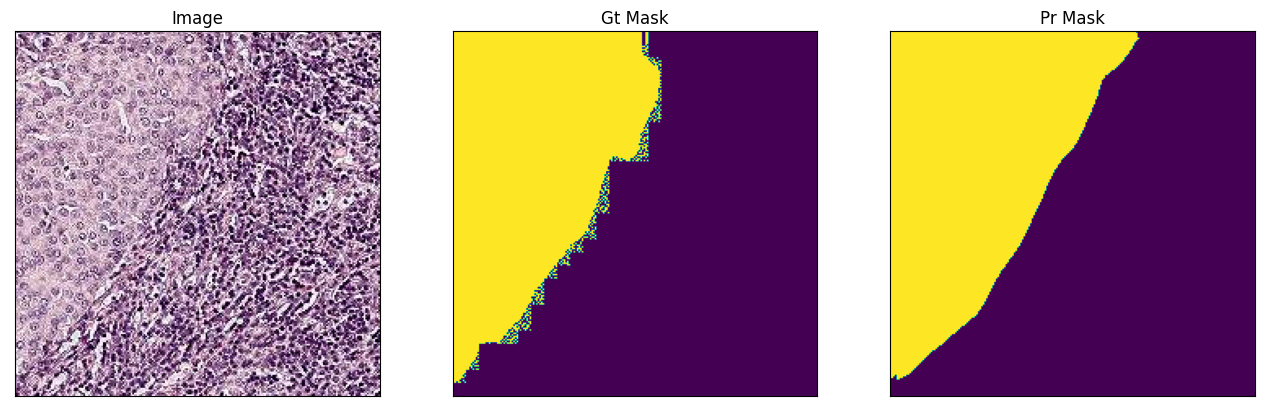

segmentation_without_full_positive_center112_level3/image/img/091_17_20.jpg
1/1 [==============================] - 0s 21ms/step


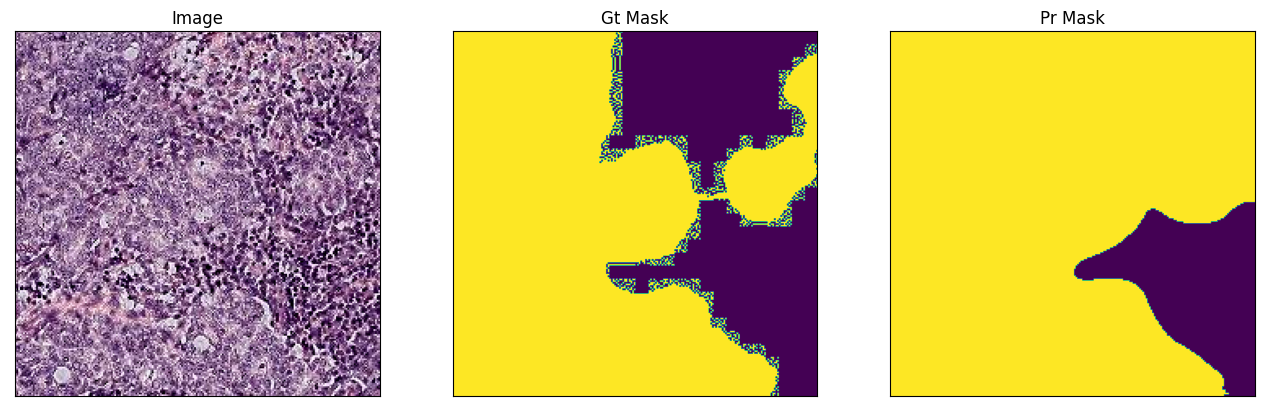

segmentation_without_full_positive_center112_level3/image/img/109_25_60.jpg
1/1 [==============================] - 0s 20ms/step


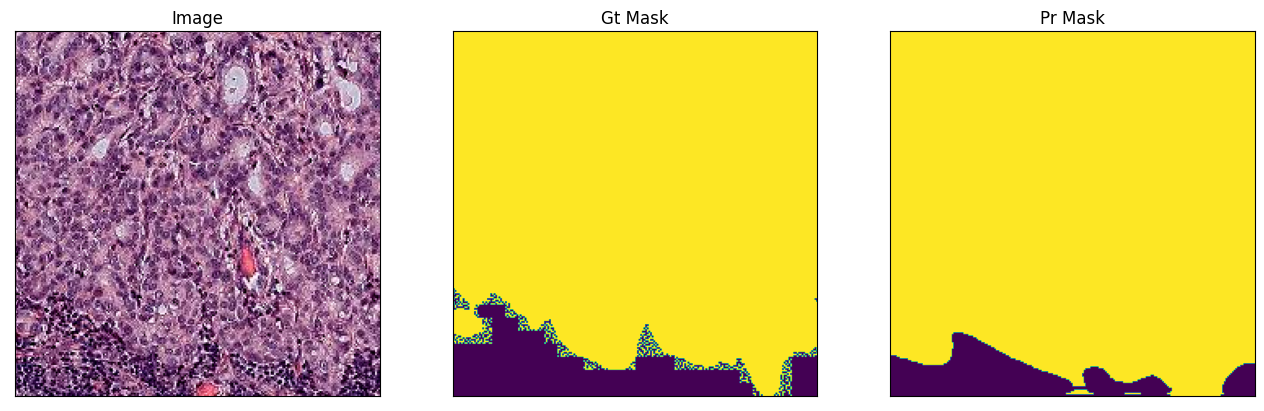

segmentation_without_full_positive_center112_level3/image/img/108_23_26.jpg
1/1 [==============================] - 0s 20ms/step


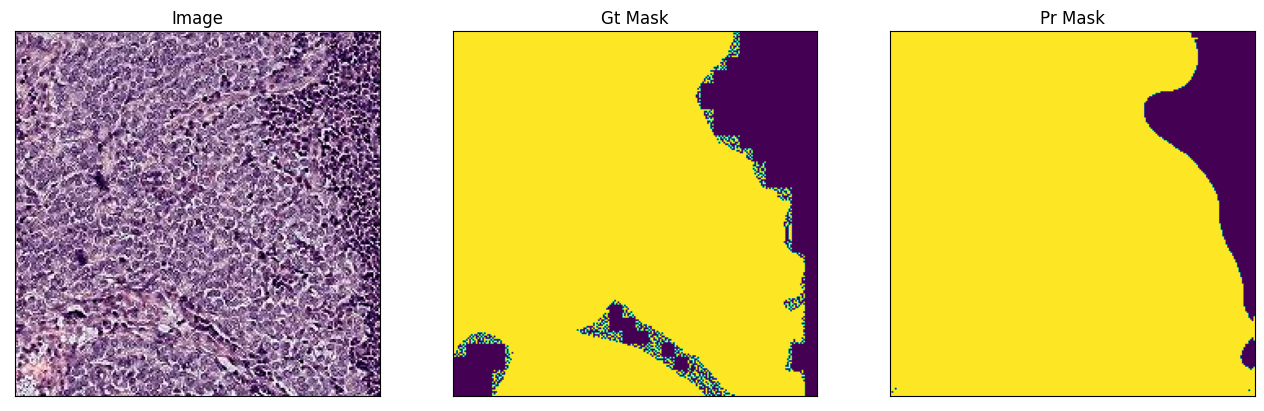

segmentation_without_full_positive_center112_level3/image/img/097_13_27.jpg
1/1 [==============================] - 0s 20ms/step


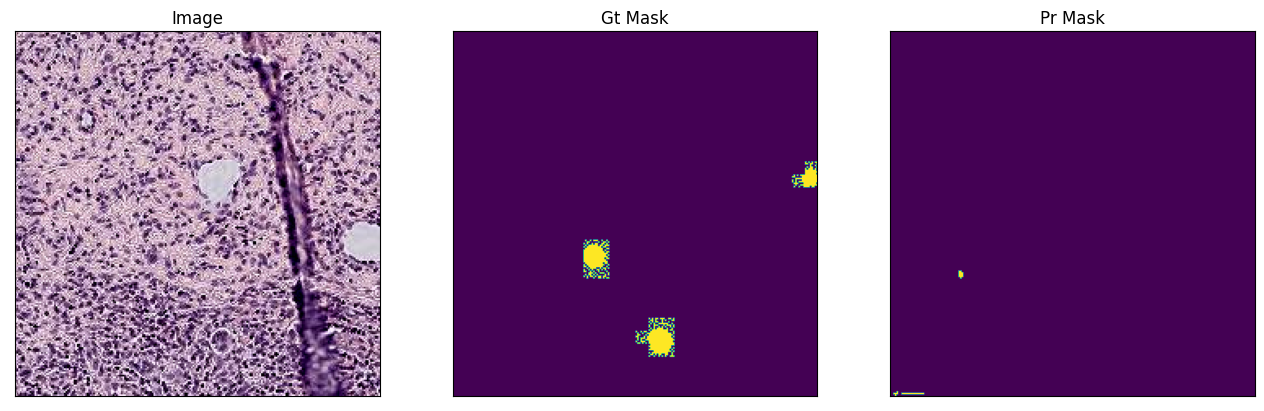

In [20]:
n = 5
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    
    image, gt_mask = valid_dataset[i]
    print(valid_dataset.images_fps[i])
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )